# Import Libraries

In [349]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import (
    train_test_split, KFold, cross_val_score, GridSearchCV)

from sklearn.preprocessing import (
    scale, LabelEncoder, StandardScaler,
    MinMaxScaler, Normalizer, RobustScaler
)

from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    precision_score, confusion_matrix, recall_score,
    roc_auc_score, roc_curve
)

# to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# The number of numbers that will be shown after the comma.
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 1.&nbsp;Load Dataset

## 1.1 Description

Data Set Story:
- It consists of 10000 observations and 12 variables.
- Independent variables contain information about customers.
- Dependent variable refers to customer abandonment.


Features:
- Surname: Surname
- CreditScore: Credit score
- Geography: Country (Germany / France / Spain)
- Gender: Gender (Female / Male)
- Age: Age
- Tenure: How many years of customer
- Balance: Balance
- NumOfProducts: Bank product used
- HasCrCard: Credit card status (0 = No, 1 = Yes)
- IsActiveMember: Active membership status (0 = No, 1 = Yes)
- EstimatedSalary: Estimated salary
- Exited: Abandoned or not? (0 = No, 1 = Yes)

In [350]:
df = pd.read_csv("churn_modeling_dataset - churn_modeling_dataset.csv", index_col=0)
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [351]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [352]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,15690940.57,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.20
std,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,15628528.25,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


In [353]:
df['CustomerId'].nunique()

10000

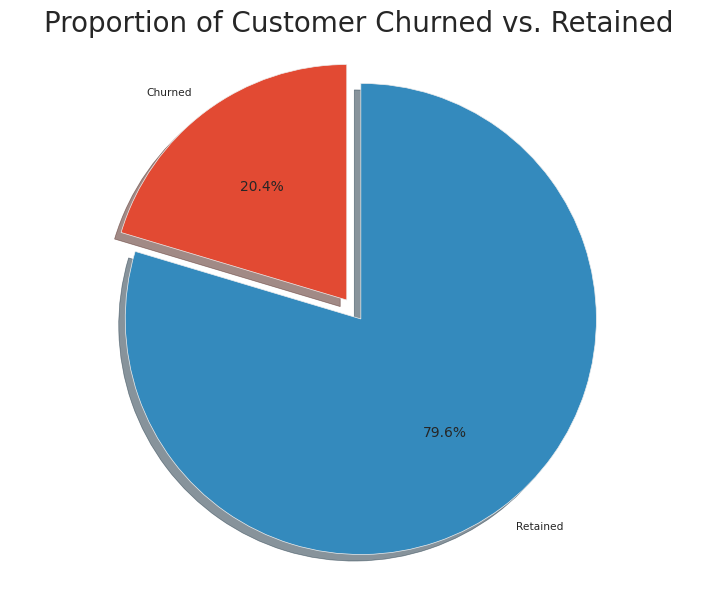

In [354]:
labels = 'Churned', 'Retained'
sizes = [
    df.Exited[df['Exited']==1].count(),
    df.Exited[df['Exited']==0].count()
]

explode = (0, 0.1)
fig, ax = plt.subplots(figsize=(9, 7))
ax.pie(
    sizes, explode=explode,
    labels=labels, autopct='%1.1f%%',
    shadow=True, startangle=90
)
ax.axis('equal')
plt.title("Proportion of Customer Churned vs. Retained", size=20)
plt.show()

# 2.&nbsp;EDA


## 2.1 Data Preparation

In [355]:
dependent_variable_name = "Exited"

In [356]:
def show_unique_count_variables(df):
    nunique_dict = {idx:[val] for idx, val in df.nunique().items()}
    df_nunique = pd.DataFrame(nunique_dict).T
    df_nunique.columns = ["unique_value_count"]
    display(df_nunique)

def data_prepare(df_raw_data):
    df_prep = df_raw_data.copy()

    missing_value_len = df.isnull().any().sum()
    if missing_value_len == 0:
        print("No Missing Value")
    else:
        print("Investigate Missing Value, Missing Value : " + str(missing_value_len))
    print("\n")

    show_unique_count_variables(df=df_prep)

    df_prep['Tenure'] = df_prep.Tenure.astype(float)
    df_prep['NumOfProducts'] = df_prep.NumOfProducts.astype(float)
    return df_prep

### 2.2. Outliers Observe (LOF method and Surpress)


#### 2.2.1. Outlier Editing

In [357]:
def show_outliers(df):
    numerics = [
        'int16', 'int32', 'int64',
        'float16', 'float32', 'float64'
    ]

    df_num_cols = df.select_dtypes(include=numerics)

    sns.set(font_scale=0.7)
    fig, axes = plt.subplots(
        nrows=2, ncols=5,
        gridspec_kw=dict(hspace=0.3),
        figsize=(12, 9)
    )

    fig.tight_layout()
    for ax, col in zip(axes.flatten(), df_num_cols.columns):
        sns.boxplot(
            x=df_num_cols[col], color='green', ax=ax
        )

    fig.suptitle('Observing Outliers', color='r', fontsize=14)

#### Notes




The Local Outlier Factor (LOF) algorithm implemented in scikit-learn calculates the local density deviation of a given data point with respect to its neighbors. The negative_outlier_factor_ attribute in scikit-learn's LOF implementation contains the opposite LOF scores for each data point. Here's how you can interpret it:

1. Local Outlier Factor (LOF):
LOF values close to 1 indicate that the data point is similar in density to its neighbors.
LOF values significantly greater than 1 indicate that the data point is in a region of lower density compared to its neighbors, suggesting it may be an outlier.
The further the LOF value is from 1, the more anomalous the data point is considered.

2. Sign of the LOF:
The negative sign in negative_outlier_factor_ simply denotes that it's the "opposite" LOF, meaning the reciprocal of the LOF values. This is done for mathematical convenience.

3. Interpretation:
Higher negative values indicate higher outlier scores, suggesting stronger evidence of being an outlier.
Lower (less negative) values indicate data points that are less likely to be outliers.

4. Thresholding:
You can set a threshold to identify outliers. Data points with negative_outlier_factor_ below a certain threshold may be considered outliers.

5. Comparing Values:
You can compare the negative_outlier_factor_ values across different data points. Points with significantly lower values compared to others might be more likely to be outliers.

6. Visualization:
Visualizing the negative_outlier_factor_ values against the data points can help identify outliers. Points with exceptionally low (highly negative) values are potential outliers.

#### 2.2.2. Visualization of outliers according to the LOF method

Source:
1. [Link_1](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html#:~:text=The%20Local%20Outlier%20Factor%20(LOF,lower%20density%20than%20their%20neighbors.)
2. [Link_2](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor)

In [358]:
def lof_observation(df):

    df_new = df.copy()

    # Select numeric columns
    numerics = [
        'int16', 'int32', 'int64',
        'float16', 'float32', 'float64'
    ]
    df_num_cols = df_new.select_dtypes(include=numerics)

    # Convert selected columns to float64
    df_outlier = df_num_cols.astype("float64")

    # Instantiate LOF model
    clf = LocalOutlierFactor(
        n_neighbors=20, contamination=0.1
    )

    # Fit model and get negative_outlier_factor
    clf.fit(df_outlier)
    np_scores = clf.negative_outlier_factor_
    print("")
    print("Sorted Outliers Score (Lowest 100):")
    print((np.sort(np_scores))[:100])
    print("")

    # Create DataFrame with sorted LOF scores
    scores_df = pd.DataFrame(
        np.sort(np_scores), columns=['LOF_Score']
    )

    # Plot LOF scores
    scores_df.plot(
        stacked=True,
        #xlim=[0, 50], # first 50 observations
        color='r',
        title='Visualization of outliers according to the LOF method',
        style='.-');

    # Determine threshold value
    th_val = -1.6  # Adjust as needed

    # Identify outliers
    outliers = np_scores <= th_val

    # Drop outliers
    df_new = df_new.drop(df_outlier[outliers].index)

    return df_new

#### 2.2.3. Outlier Suppression

In [359]:
def clear_outliers(df):

    # For Age
    Q1 = df["Age"].quantile(0.25)
    Q3 = df["Age"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print("Surpress 'Age' if,")
    print("below lower score:", lower)
    print("upper score:", upper)
    print("")
    df.loc[(df["Age"] > upper), "Age"] = upper

    # For Credit Score
    Q1 = df["CreditScore"].quantile(0.25)
    Q3 = df["CreditScore"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print("Surpress 'CreditScore' if,")
    print("below lower score:", lower)
    print("upper score:", upper)
    print("")
    df.loc[(df["CreditScore"] < lower), "CreditScore"] = lower
    return df

#### 2.2.4. Outlier Process

In [360]:
def outlier_cleaning_process(df):
    df_clean = lof_observation(df=df)
    df_clean = clear_outliers(df=df_clean)
    return df_clean

### 2.3. Data Analysis
#### 2.3.1. Dependent variable distribution

In [361]:
def show_dependent_variable(df):
    fig, axarr = plt.subplots(2, 3, figsize=(18, 6))
    sns.countplot(x='Geography', hue='Exited', data=df, ax=axarr[0][0])
    sns.countplot(x='Gender', hue='Exited', data=df, ax=axarr[0][1])
    sns.countplot(x='HasCrCard', hue='Exited', data=df, ax=axarr[0][2])
    sns.countplot(x='IsActiveMember', hue='Exited', data=df, ax=axarr[1][0])
    sns.countplot(x='NumOfProducts', hue='Exited', data=df, ax=axarr[1][1])
    sns.countplot(x='Tenure', hue='Exited', data=df, ax=axarr[1][2])
    zero, one = df[dependent_variable_name].value_counts()
    print("Dependent variable distribution;")
    print(dependent_variable_name + " 0 count:", zero)
    print(dependent_variable_name + " 1 count:", one)
    print("")

#### 2.3.2. Numeric columns distribution observation

In [362]:
def show_numeric_columns_distributions(df):
    numerics = [
        'int16', 'int32', 'int64',
        'float16', 'float32', 'float64'
    ]
    df_num_cols = df.select_dtypes(include=numerics)
    columns = df_num_cols.columns[: len(df_num_cols.columns)]
    fig = plt.figure()
    fig.set_size_inches(18, 15)
    length = len(columns)
    for i,j in itertools.zip_longest(columns, range(length)):
        plt.subplot(int(length/2), 3, j+1)
        plt.subplots_adjust(wspace=0.2, hspace=0.5)
        df_num_cols[i].hist(bins=20, edgecolor='black')
        plt.title(i)
    fig = fig.suptitle('Structures of numeric variables', color='r', fontsize=18)
    plt.show()

#### 2.3.3. Status of other variables according to dependent variable

In [363]:
def show_dependent_variable_cross_others_distributions(df):
    numerics = [
        'int16', 'int32', 'int64',
        'float16', 'float32', 'float64'
    ]
    df_dependent_var = df[df[dependent_variable_name]==1]
    df_num_cols = df_dependent_var.select_dtypes(include=numerics)
    columns = df_num_cols.columns[:len(df_num_cols.columns)]

    fig = plt.figure()
    fig.set_size_inches(18, 15)
    length = len(columns)
    for i,j in itertools.zip_longest(columns, range(length)):
        plt.subplot(int(length/2), 3, j+1)
        plt.subplots_adjust(wspace=0.2, hspace=0.5)
        df_num_cols[i].hist(bins=20, edgecolor='black')
        plt.title(i)
    fig = fig.suptitle(
        dependent_variable_name+'Status of other variables according to 1 dependent variable',
        color='r', fontsize=18)
    plt.show()

#### 2.3.4. Categorical variables are observed according to the dependent variable

In [364]:
def show_dependent_variable_cross_categorical_distributions(df, categorical_columns):
    sns.set(font_scale=0.7)
    fig, axes = plt.subplots(
        nrows=int(len(categorical_columns)/2 ),
        ncols=2,
        figsize=(7,9)
    )
    fig.tight_layout()
    for ax,col in zip(axes.flatten(), categorical_columns):
        sns.countplot(
            x=df[col], hue=dependent_variable_name,
            data=df, ax=ax
        )
    fig.suptitle(
        'Categorical variables are monitored according to the dependent variable',
        color='r', fontsize=1
    )

#### 2.3.5. The main method that started all data analysis

In [365]:
def show_data_analysis(df):
    show_dependent_variable(df)
    show_numeric_columns_distributions(df)
    show_dependent_variable_cross_others_distributions(df)
    show_dependent_variable_cross_categorical_distributions(
        df=df_outlier,
        categorical_columns=[
            "Gender", "Geography", "HasCrCard", "IsActiveMember"
        ]
    )

## 3.&nbsp;Feature Engineering

In [366]:
def credit_score_table(row):
    credit_score = row.CreditScore
    if credit_score < 300:
      return "Deep"
    elif 300 <= credit_score < 500:
        return "Very_Poor"
    elif 500 <= credit_score < 601:
        return "Poor"
    elif 601 <= credit_score < 661:
        return "Fair"
    elif 661 <= credit_score < 781:
        return "Good"
    elif 781 <= credit_score < 851:
        return "Excellent"
    else:
        return "Top"

### 3.2. Product utilization RATE by YEAR

In [367]:
def product_utilization_rate_by_year(row):
    number_of_products = row.NumOfProducts
    tenure = row.Tenure

    if number_of_products == 0:
        return 0

    if tenure == 0:
        return number_of_products

    rate = number_of_products/tenure
    return rate

### 3.3. Product utilization RATE by estimated SALARY

In [368]:
def product_utilization_rate_by_estimated_salary(row):
    number_of_products = row.number_of_products
    estimated_salary = row.EstimatedSalary

    if number_of_products == 0:
        return 0

    rate = number_of_products / estimated_salary
    return rate

### 3.4. According to countries monthly average salaries

reference: [Link](https://en.wikipedia.org/wiki/List_of_European_countries_by_average_wage)

In [369]:
def countries_monthly_average_salaries(row):
    fr = 3696
    de = 4740
    sp = 2257
    salary = row.EstimatedSalary / 12
    country = row.Geography # Germany, France and Spain

    if country == 'Germany':
        return salary / de
    elif country == "France":
        return salary / fr
    elif country == "Spain":
        return salary / sp

### 3.5. The main method that started all Feature Engineering

In [370]:
def feature_engineering(df, is_show_graph = False):
    df_fe = df.copy()

    balance_salary_rate = 'balance_salary_rate'
    df_fe[balance_salary_rate] = df_fe.Balance / df_fe.EstimatedSalary

    df_fe = df_fe.assign(
        product_utilization_rate_by_year=df_fe.apply(
            lambda x: product_utilization_rate_by_year(x),
            axis=1
            )
        )

    tenure_rate_by_age = 'tenure_rate_by_age'
    df_fe[tenure_rate_by_age] = df_fe.Tenure/(df_fe.Age - 17)

    credit_score_rate_by_age = 'credit_score_rate_by_age'
    df_fe[credit_score_rate_by_age] = df_fe.CreditScore/(df_fe.Age - 17)

    product_utilization_rate_by_salary = 'product_utilization_rate_by_salary'

    credit_score_rate_by_salary = 'credit_score_rate_by_salary'
    df_fe[credit_score_rate_by_salary] = df_fe.CreditScore/(df_fe.EstimatedSalary)

    if is_show_graph:
        fig, axes = plt.subplots(
            nrows=2, ncols=2, figsize=(20,12))
        fig.tight_layout()
        sns.boxplot(
            y=balance_salary_rate,
            x=dependent_variable_name,
            hue=dependent_variable_name,
            data=df_fe,
            ax=axes[0][0]
        )
        sns.boxplot(
            y=product_utilization_rate_by_year,
            x=dependent_variable_name,
            hue=dependent_variable_name,
            data=df_fe,
            ax=axes[0][1]
        )
        plt.ylim(-1, 5)

    df_fe = df_fe.assign(credit_score_table=df_fe.apply(lambda x: credit_score_table(x), axis=1))
    df_fe = df_fe.assign(countries_monthly_average_salaries = df_fe.apply(lambda x: countries_monthly_average_salaries(x), axis=1))
    return df_fe

# 4.&nbsp;Data Encoding

In [371]:
def data_encoding(df):
    df_model = df.copy()
    # >>>> Categorical columns <<<<<
    non_encoding_columns = [
        "Geography", "HasCrCard","IsActiveMember",
        "Gender", "NumOfProducts", "Tenure", "credit_score_table"]

    df_non_encoding = df_model[non_encoding_columns]
    df_model = df_model.drop(non_encoding_columns, axis=1)
    df_encoding = df_non_encoding.copy()

    encoder = LabelEncoder()
    df_encoding["gender_category"] = encoder.fit_transform(df_non_encoding.Gender)
    df_encoding["country_category"] = encoder.fit_transform(df_non_encoding.Geography)
    df_encoding["credit_score_category"] = encoder.fit_transform(df_non_encoding.credit_score_table)

    df_encoding.reset_index(drop=True, inplace=True)
    df_model.reset_index(drop=True, inplace=True)
    df_model = pd.concat([df_model, df_encoding], axis=1)

    df_model = df_model.drop(
        ["Geography", "Gender" , "CustomerId", "Surname",
         "credit_score_table", "CreditScore", "EstimatedSalary"],
        axis=1)

    df_model = df_model.reset_index()
    df_model = df_model.drop('index', axis=1)

    df_model.loc[df_model.HasCrCard==0, 'credit_card_situation'] = -1
    df_model.loc[df_model.IsActiveMember==0, 'is_active_member'] = -1
    return df_model

In [372]:
df[df.IsActiveMember==0]["Exited"].value_counts()

Exited
0    3547
1    1302
Name: count, dtype: int64

# 5.&nbsp;Model Preparation

In [373]:
def model_prepare(df_model):

    X = df_model.loc[:, df_model.columns != dependent_variable_name]
    y = df_model[dependent_variable_name]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

### 5.1 Part of Data Train

In [374]:
def data_training(X_train, X_test, y_train, y_test):

    models = []
    models.append(('LOGR', LogisticRegression()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('GBM', GradientBoostingClassifier()))
    models.append(('XGBoost', XGBClassifier()))
    models.append(('LightGBM', LGBMClassifier()))

    res_cols = [
        'model', 'accuracy_score', 'scale_method',
        "0_precision", "0_recall", "1_precision", "1_recall"
    ]
    df_result = pd.DataFrame(columns=res_cols)

    index = 0
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, digits=2, output_dict=True)
        zero_report = class_report['0']
        one_report = class_report['1']
        res_vals = [
            name, score, "NA",
            zero_report['precision'], zero_report['recall'],
            one_report['precision'], one_report['recall']
        ]
        df_result.at[index, res_cols] = res_vals
        index += 1
    return df_result.sort_values("accuracy_score", ascending=False)

# 6.&nbsp;HELPER Functions

In [375]:
# Function to give best model score and parameters

def best_model(model):
    print(model.best_score_)
    print(model.best_params_)
    print(model.best_estimator_)

def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method);
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2);
    return (auc_score, fpr_df, tpr_df)

from matplotlib import rc, rcParams
def plot_confusion_matrix(
    cm, classes, normalize=False,
    title='Confusion Matrix', cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.rcParams.update({'font.size': 16})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color="blue")
    plt.yticks(tick_marks, classes, color="blue")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="red" if cm[i, j] > thresh else "black"
        )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 7.&nbsp;Data Cleaning

No Missing Value




,unique_value_count
CustomerId,10000
Surname,2932
CreditScore,460
Geography,3
Gender,2
Age,70
Tenure,11
Balance,6382
NumOfProducts,4
HasCrCard,2



Sorted Outliers Score (Lowest 100):
[-3.08555878 -2.93472746 -2.84794485 -2.76659104 -2.6850911  -2.62052331
 -2.60962632 -2.58668518 -2.58413555 -2.51931412 -2.48271434 -2.37159865
 -2.37065285 -2.355955   -2.32588054 -2.10245281 -2.06452981 -2.05046445
 -1.95312565 -1.88343633 -1.76682867 -1.75518011 -1.75306602 -1.68547216
 -1.66616785 -1.65946618 -1.65692693 -1.63787941 -1.63556438 -1.60001244
 -1.5925949  -1.55424873 -1.55254456 -1.53014738 -1.52924071 -1.52530458
 -1.52498503 -1.52174212 -1.51586411 -1.51576939 -1.50046862 -1.4855679
 -1.45633923 -1.4526947  -1.44164203 -1.43302056 -1.42694854 -1.41758041
 -1.41211277 -1.40487556 -1.40353593 -1.38891118 -1.38739766 -1.38487442
 -1.3832952  -1.3764266  -1.3660788  -1.3659226  -1.36191449 -1.35913365
 -1.35870259 -1.35798801 -1.35212962 -1.35055547 -1.34781708 -1.34730944
 -1.34536188 -1.34387538 -1.3412761  -1.33954466 -1.33854032 -1.33746276
 -1.33265772 -1.33176715 -1.33116468 -1.33001482 -1.32487216 -1.32378787
 -1.32345934 -1

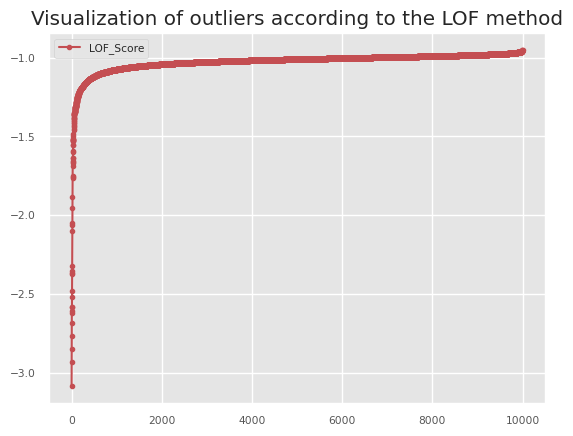

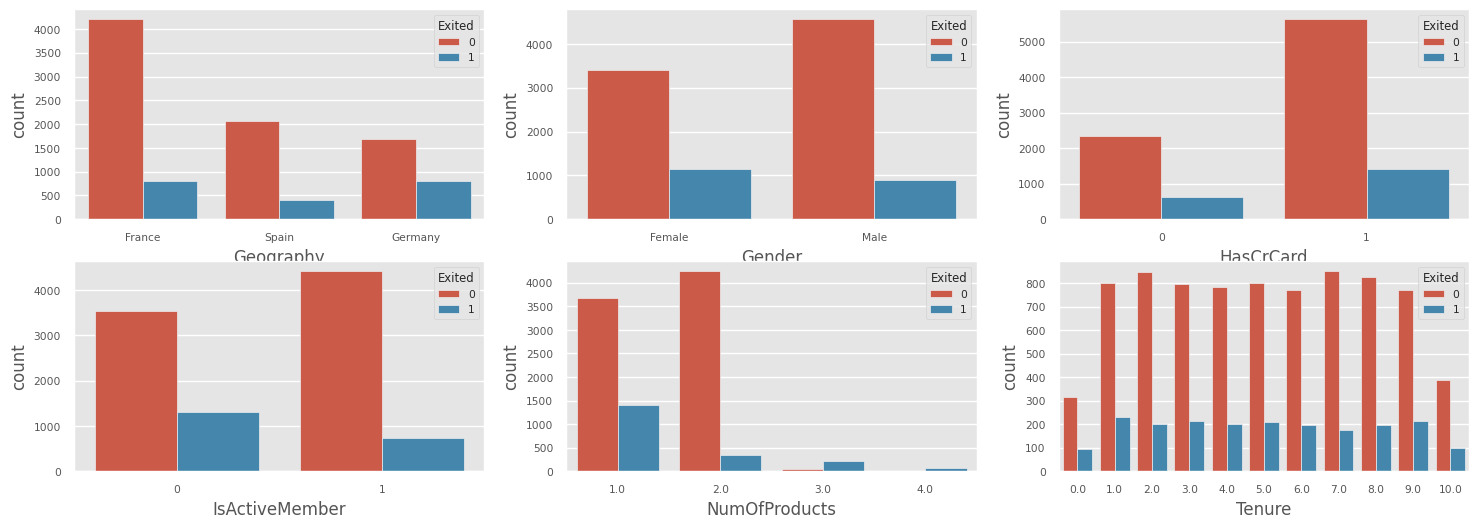

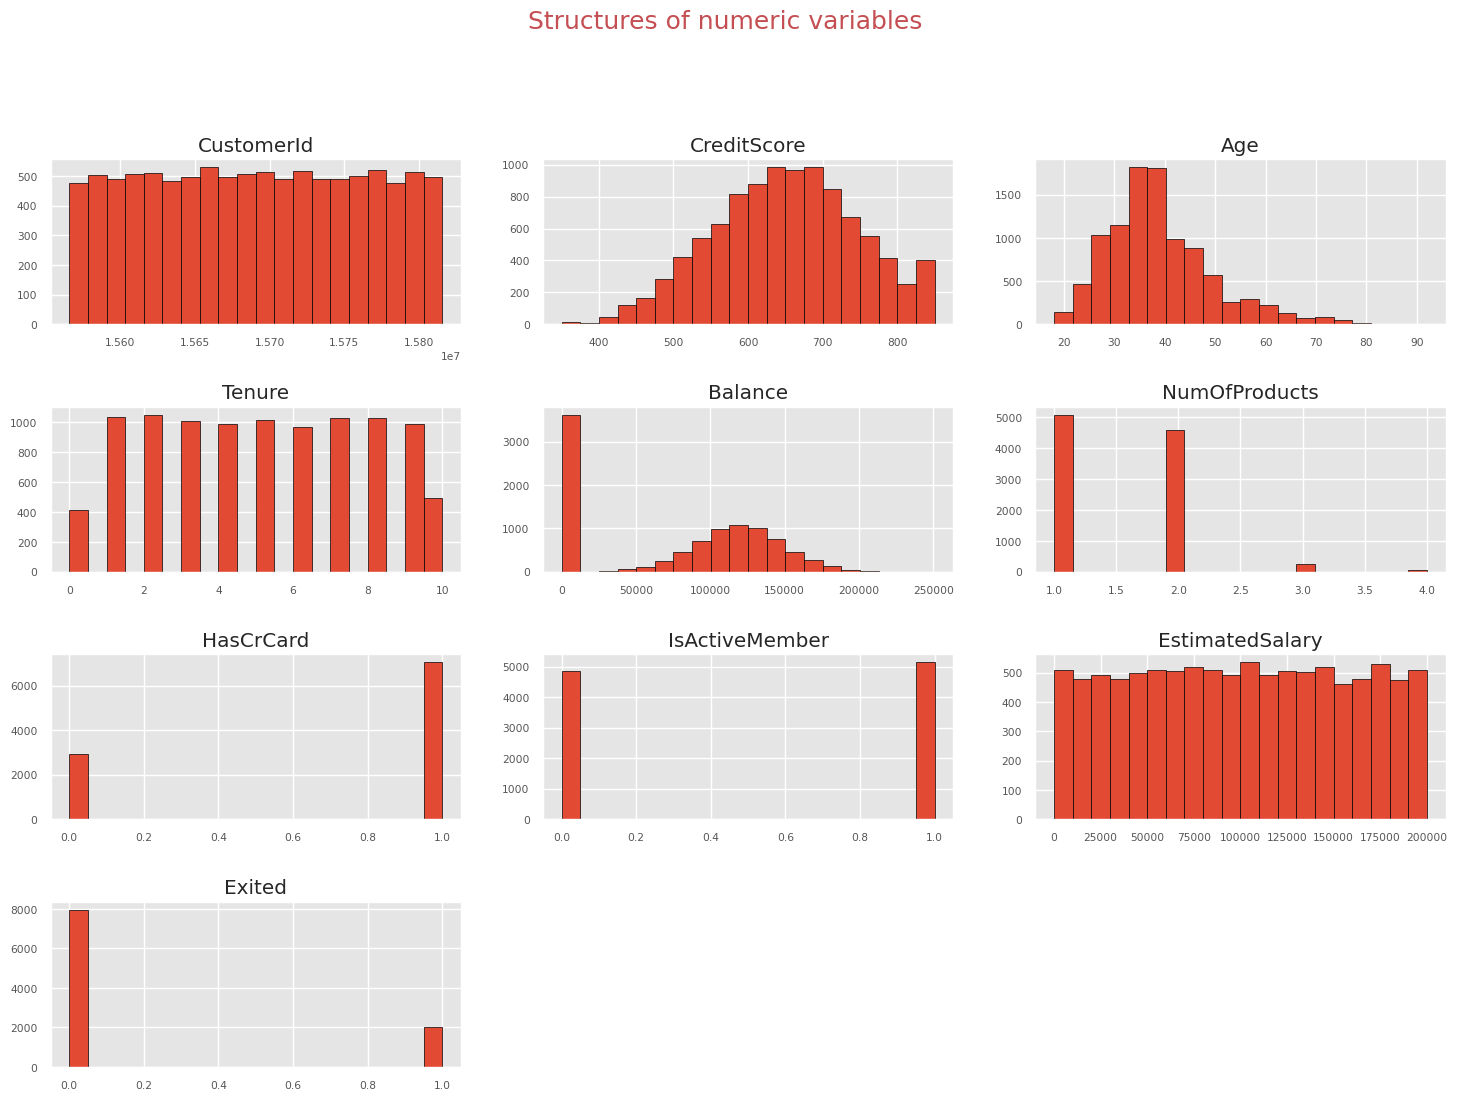

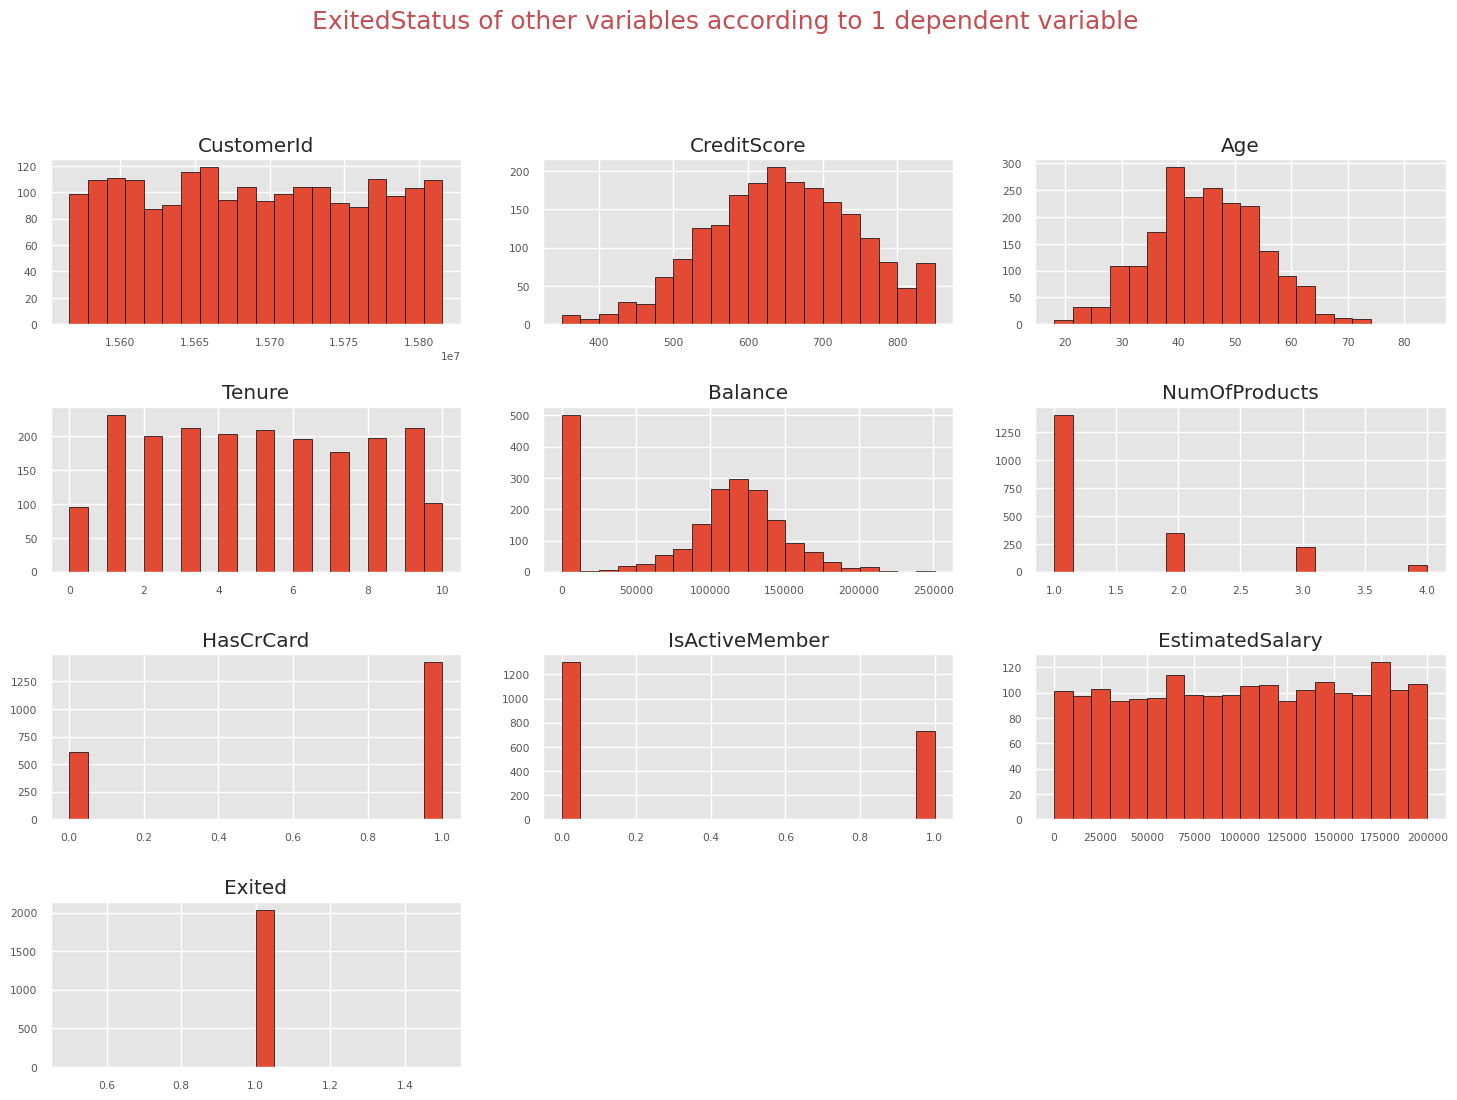

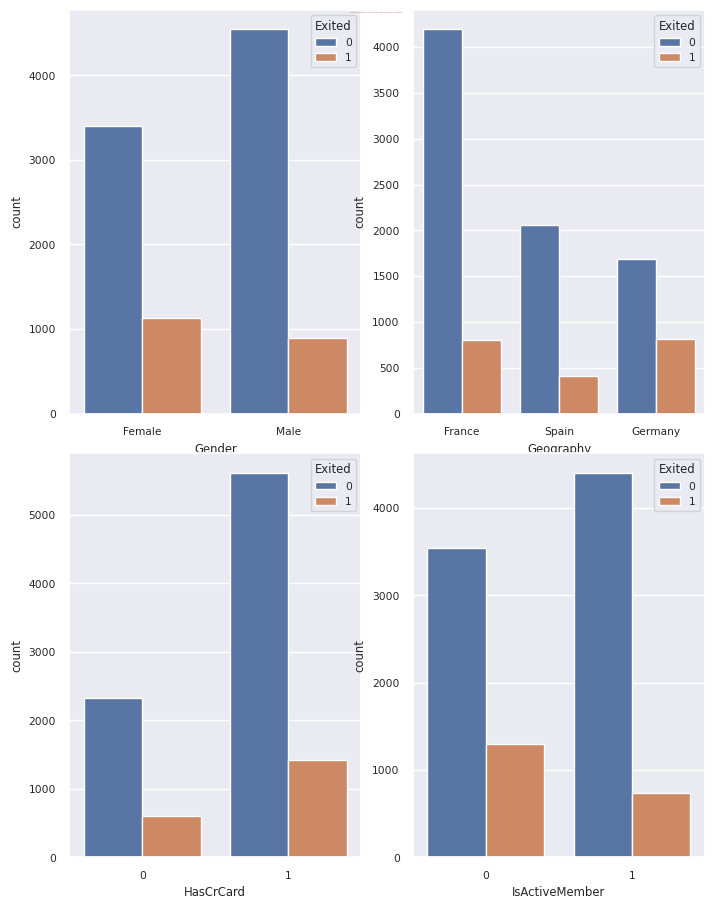

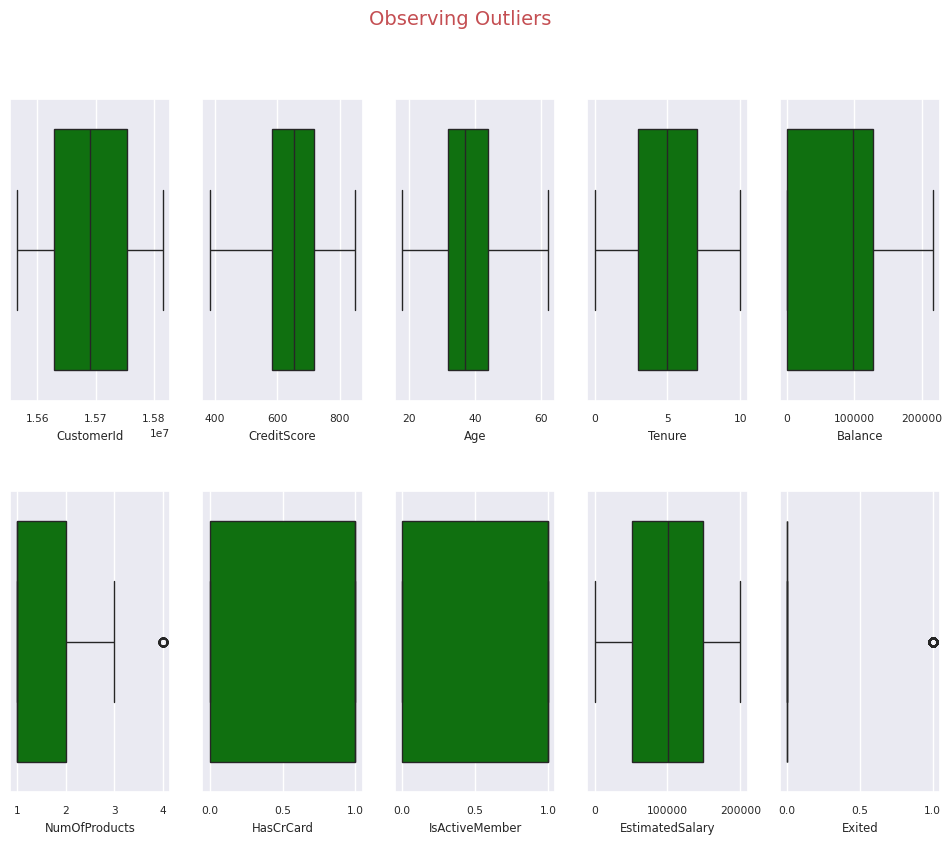

In [376]:
df_prep = data_prepare(df)
df_outlier = outlier_cleaning_process(df=df_prep)

show_data_analysis(df_prep)
show_outliers(df=df_outlier)

Let's see after feature engineering:

In [377]:
df_fe = feature_engineering(df=df_outlier)
df_fe.head(3)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,balance_salary_rate,product_utilization_rate_by_year,tenure_rate_by_age,credit_score_rate_by_age,credit_score_rate_by_salary,credit_score_table,countries_monthly_average_salaries
RowNumber,,,,,,,,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1.00,1,1,101348.88,1,0.00,0.50,0.08,24.76,0.01,Fair,2.29
2,15647311,Hill,608,Spain,Female,41,1.00,83807.86,1.00,0,1,112542.58,0,0.74,1.00,0.04,25.33,0.01,Fair,4.16
3,15619304,Onio,502,France,Female,42,8.00,159660.80,3.00,1,0,113931.57,1,1.40,0.38,0.32,20.08,0.00,Poor,2.57


And see after data encoding:

In [378]:
df_encoded = data_encoding(df_fe)
df_encoded.drop(
    columns=['credit_card_situation', 'is_active_member'],
    inplace=True
)
df_encoded.head(5)

,Age,Balance,Exited,balance_salary_rate,product_utilization_rate_by_year,tenure_rate_by_age,credit_score_rate_by_age,credit_score_rate_by_salary,countries_monthly_average_salaries,HasCrCard,IsActiveMember,NumOfProducts,Tenure,gender_category,country_category,credit_score_category
0,42,0.00,1,0.00,0.50,0.08,24.76,0.01,2.29,1,1,1.00,2.00,0,0,1
1,41,83807.86,0,0.74,1.00,0.04,25.33,0.01,4.16,0,1,1.00,1.00,0,2,1
2,42,159660.80,1,1.40,0.38,0.32,20.08,0.00,2.57,1,0,3.00,8.00,0,0,3
3,39,0.00,0,0.00,2.00,0.05,31.77,0.01,2.12,0,0,2.00,1.00,0,0,2
4,43,125510.82,0,1.59,0.50,0.08,32.69,0.01,2.92,1,1,1.00,2.00,0,2,0


Now, let's see correlation graph:

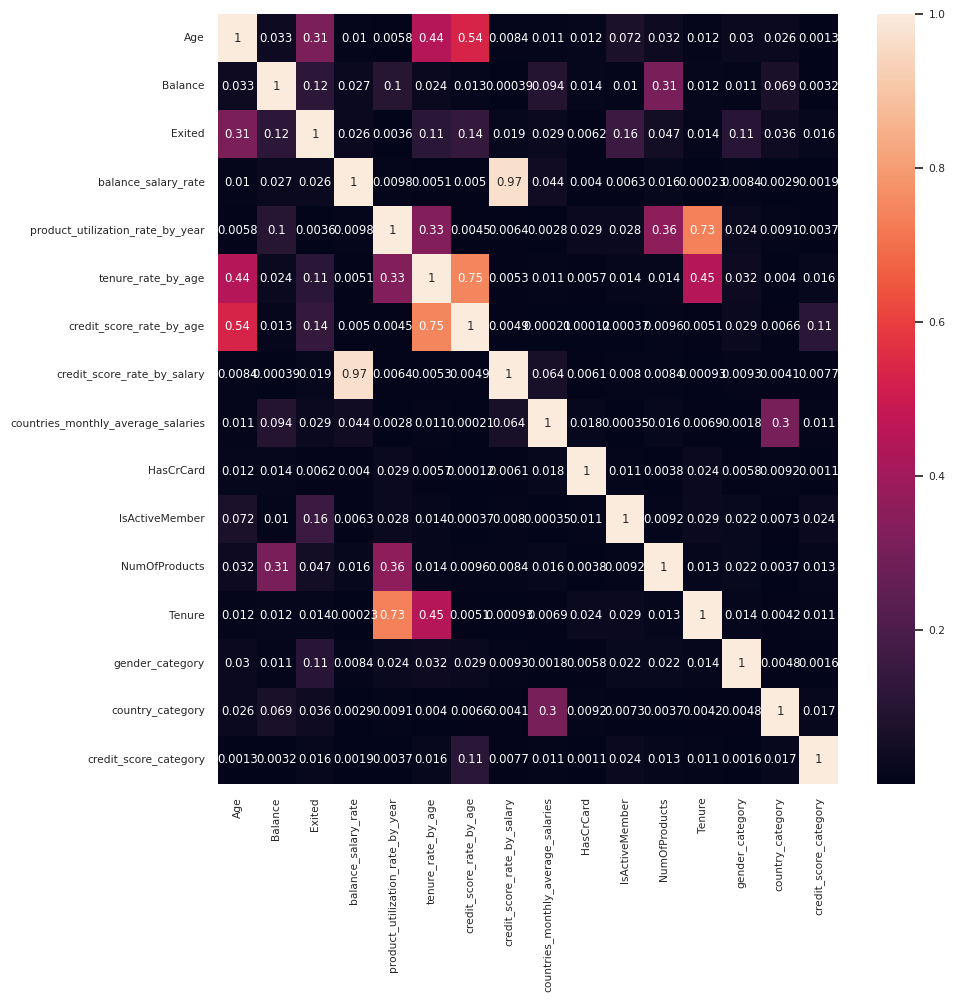

In [379]:
correlation = df_encoded.corr().abs()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, annot=True)
plt.show()

List of correlation scores:

In [380]:
corrs_results = df_encoded.corrwith(df_encoded["Exited"]).abs().nlargest(24)
corrs_results

Exited                               1.00
Age                                  0.31
IsActiveMember                       0.16
credit_score_rate_by_age             0.14
Balance                              0.12
tenure_rate_by_age                   0.11
gender_category                      0.11
NumOfProducts                        0.05
country_category                     0.04
countries_monthly_average_salaries   0.03
balance_salary_rate                  0.03
credit_score_rate_by_salary          0.02
credit_score_category                0.02
Tenure                               0.01
HasCrCard                            0.01
product_utilization_rate_by_year     0.00
dtype: float64

# 8.&nbsp;Apply Model

In [381]:
# model_prepare test, train split 0.2
X_train, X_test, y_train, y_test = model_prepare(df_model=df_encoded)

### 8.1. Logistic Regression Model

Have a look with Logistic Regression.

In [382]:
logr_model = LogisticRegression()
logr_model.fit(X_train, y_train)
y_pred = logr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred, digits=4))
print("Accuracy score of Logistic Regression: ", accuracy)

              precision    recall  f1-score   support

           0     0.8398    0.9687    0.8997      1597
           1     0.6711    0.2569    0.3716       397

    accuracy                         0.8270      1994
   macro avg     0.7555    0.6128    0.6356      1994
weighted avg     0.8062    0.8270    0.7945      1994

Accuracy score of Logistic Regression:  0.8269809428284854


### 8.2. Model Training

This is for all LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, and LGBMClassifier model objects:

In [383]:
def data_training(X_train, X_test, y_train, y_test):

    models = []
    models.append(('LOGR', LogisticRegression()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('GBM', GradientBoostingClassifier()))
    models.append(('XGBoost', XGBClassifier()))
    models.append(('LightGBM', LGBMClassifier()))

    res_cols = ["model", "accuracy_score", "scale_method", "0_precision", "0_recall", "1_precision", "1_recall"]
    df_result = pd.DataFrame(columns=res_cols)
    index = 0
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, digits=2, output_dict=True)
        zero_report = class_report['0']
        one_report = class_report['1']

        idx_res_values = [name, score, "NA", zero_report['precision'], zero_report['recall'], one_report['precision'], one_report['recall']]
        # df_result.at[index, res_cols] = idx_res_values
        df_result.loc[index, res_cols] = idx_res_values
        index += 1
    df_result = df_result.sort_values("accuracy_score", ascending=False).reset_index(drop=True)
    return df_result

In [384]:
training_result = data_training(X_train, X_test, y_train, y_test)
training_result

[LightGBM] [Info] Number of positive: 1627, number of negative: 6349
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1625
[LightGBM] [Info] Number of data points in the train set: 7976, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203987 -> initscore=-1.361559
[LightGBM] [Info] Start training from score -1.361559


,model,accuracy_score,scale_method,0_precision,0_recall,1_precision,1_recall
0,RF,0.86,NA,0.87,0.97,0.78,0.44
1,LightGBM,0.86,NA,0.88,0.96,0.74,0.48
2,GBM,0.86,NA,0.88,0.96,0.75,0.45
3,XGBoost,0.85,NA,0.88,0.94,0.66,0.48
4,KNN,0.84,NA,0.86,0.95,0.65,0.39
5,LOGR,0.83,NA,0.84,0.97,0.67,0.26
6,CART,0.78,NA,0.86,0.86,0.46,0.46


# 9.&nbsp;Model Tuning

### 9.1. XGBoost Tuning

In [385]:
# #default soal
# xgb_model=XGBClassifier(
#     learning_rate=0.23,
#     max_delta_step=5,
#     objective='reg:logistic',
#     n_estimators=92,
#     max_depth=5,
#     eval_metric="logloss",
#     gamma=3,
#     base_score=0.5
# )

# xgb_model.fit(X_train, y_train)
# y_pred = xgb_model.predict(X_test)
# print(classification_report(y_test, y_pred, digits=2))
# print("Accuracy score of Tuned XGBoost Regression: ", accuracy_score(y_test, y_pred))

# from sklearn.model_selection import GridSearchCV


# -----------------------------------------------------------------------------

# # jawaban Hyperparameter tuning for XGBoost percoban 1 running 43menit
# xgb_params = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'min_child_weight': [1, 3, 5],
#     'gamma': [0, 0.1, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'n_estimators': [50, 100, 200]
# }

# xgb_grid = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic'), param_grid=xgb_params, scoring='recall', cv=5)
# xgb_grid.fit(X_train, y_train)

# print("Best parameters for XGBoost:", xgb_grid.best_params_)
# print("Best recall score for XGBoost:", xgb_grid.best_score_)
# output:
# Best parameters for XGBoost: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.6}
# Best recall score for XGBoost: 0.505208117036338




# ------------------------------------------------------------------------------
# jawaban Hyperparameter tuning for XGBoost percoban 2 1jam
# xgb_params = {
#     'learning_rate': [0.23, 0.33, 0.43],
#     'max_delta_step':[4, 5, 6],
#     'max_depth': [4, 5, 6],
#     'min_child_weight': [5, 6, 7],
#     'gamma': [0, 2, 3, 4],
#     'subsample': [0.4, 0.6, 0.8,],
#     'colsample_bytree': [1.0, 2.0, 3.0],
#     'n_estimators': [92, 200, 250]
# }

# xgb_grid = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic'), param_grid=xgb_params, scoring='recall', cv=5)
# xgb_grid.fit(X_train, y_train)

# print("Best parameters for XGBoost:", xgb_grid.best_params_)
# print("Best recall score for XGBoost:", xgb_grid.best_score_)
# y_pred = xgb_grid.predict(X_test)
# print(classification_report(y_test, y_pred, digits=2))
# print("Accuracy score of tuned xgb model: ", accuracy_score(y_test, y_pred))

# OUTPUT
# Best parameters for XGBoost: {'colsample_bytree': 1.0, 'gamma': 2, 'learning_rate': 0.43, 'max_delta_step': 4, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 92, 'subsample': 0.4}
# Best recall score for XGBoost: 0.516896649362907
#               precision    recall  f1-score   support

#            0       0.88      0.94      0.90      1597
#            1       0.64      0.47      0.54       397

#     accuracy                           0.84      1994
#    macro avg       0.76      0.70      0.72      1994
# weighted avg       0.83      0.84      0.83      1994

# Accuracy score of tuned xgb model:  0.8425275827482447

In [386]:
#hasil tuned dengan best parameters
xgb_model = XGBClassifier(
    learning_rate=0.2,
    colsample_bytree=1.0,
    max_delta_step=4,
    subsample=0.4,
    objective='reg:logistic',
    n_estimators=100,
    max_depth=5,
    eval_metric="logloss",
    gamma=3,
    base_score=0.5
)


xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=2))
print("Accuracy score of Tuned XGBoost Regression: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1597
           1       0.75      0.52      0.61       397

    accuracy                           0.87      1994
   macro avg       0.82      0.74      0.77      1994
weighted avg       0.86      0.87      0.86      1994

Accuracy score of Tuned XGBoost Regression:  0.8706118355065195


### 9.2. Random Forest Tuning

In [387]:
'''
param_grid = {
    'max_depth': [3, 5, 6, 7, 8],
    'max_features': [2, 4, 6, 7, 8, 9],
    'n_estimators' : [50, 100],
    'min_samples_split': [3, 5, 6, 7]
}

randFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, refit = True, verbose = 0)
randFor_grid.fit(X_train, y_train)
best_model(randFor_grid)
'''

# skipped, running too long

# # Hyperparameter tuning for Random Forest percobaan 1 running 14menit
# #Best parameters for Random Forest: {'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
# # Best recall score for Random Forest: 0.37615478999528074
# rf_params = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# rf_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_params, scoring='recall', cv=5)
# rf_grid.fit(X_train, y_train)

# print("Best parameters for Random Forest:", rf_grid.best_params_)
# print("Best recall score for Random Forest:", rf_grid.best_score_)



# ----------------------------------------------------------------------------
# # Hyperparameter tuning for Random Forest percobaan 2
# rf_params = {
#     'n_estimators': [40, 50, 100],
#     'max_depth': [7, 8, 9],
#     'min_samples_split': [6, 10, 12],
#     'min_samples_leaf': [0, 1, 2],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# rf_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_params, scoring='recall', cv=5)
# rf_grid.fit(X_train, y_train)

# print("Best parameters for Random Forest:", rf_grid.best_params_)
# print("Best recall score for Random Forest:", rf_grid.best_score_)
# y_pred = rf_grid.predict(X_test)
# print(classification_report(y_test, y_pred, digits=2))
# print("Accuracy score of tuned Random Forest model: ", accuracy_score(y_test, y_pred))

# # output
# # Best parameters for Random Forest: {'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 40}
# # Best recall score for Random Forest: 0.4019499764039641
# #               precision    recall  f1-score   support

# #            0       0.87      0.97      0.92      1597
# #            1       0.80      0.41      0.54       397

# #     accuracy                           0.86      1994
# #    macro avg       0.84      0.69      0.73      1994
# # weighted avg       0.86      0.86      0.84      1994

# # Accuracy score of tuned Random Forest model:  0.8625877632898696

"\nparam_grid = {\n    'max_depth': [3, 5, 6, 7, 8],\n    'max_features': [2, 4, 6, 7, 8, 9],\n    'n_estimators' : [50, 100],\n    'min_samples_split': [3, 5, 6, 7]\n}\n\nrandFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, refit = True, verbose = 0)\nrandFor_grid.fit(X_train, y_train)\nbest_model(randFor_grid)\n"

Using the parameters and get final version accuracy score.

In [388]:
# DEFAULT TUNINGNYA
# rnd_model = RandomForestClassifier(
#     max_depth=8,
#     max_features=6,
#     min_samples_split=6,
#     n_estimators=50
# )

# rnd_model.fit(X_train, y_train)
# y_pred = rnd_model.predict(X_test)
# print(classification_report(y_test, y_pred, digits=2))
# print("Accuracy score of tuned Random Forest model: ", accuracy_score(y_test, y_pred))



# HASIL EDIT
rnd_model = RandomForestClassifier(
    max_depth=9,
    max_features=6,
    min_samples_split=6,
    min_samples_leaf= 2,
    n_estimators=50
)

rnd_model.fit(X_train, y_train)
y_pred = rnd_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=2))
print("Accuracy score of tuned Random Forest model: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1597
           1       0.81      0.43      0.56       397

    accuracy                           0.87      1994
   macro avg       0.84      0.70      0.74      1994
weighted avg       0.86      0.87      0.85      1994

Accuracy score of tuned Random Forest model:  0.8655967903711134


### 9.3. LightGBM Tuning

In [389]:
# lgbm_model = LGBMClassifier(
#     silent = 0,
#     learning_rate = 0.09,
#     max_delta_step = 2,
#     n_estimators = 100,
#     boosting_type = 'gbdt',
#     max_depth = 10,
#     eval_metric = "logloss",
#     gamma = 3,
#     base_score = 0.5
# )

# lgbm_model.fit(X_train, y_train)
# y_pred = lgbm_model.predict(X_test)
# print(classification_report(y_test, y_pred, digits=2))
# print("Accuracy score of tuned LightGBM model: ", accuracy_score(y_test, y_pred))




# -----------------------------------------------------------------------------------
# # Hyperparameter tuning for LightGBM percobaan 1 40menit
# lgbm_params = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'num_leaves': [25, 31, 40],
#     'min_child_samples': [20, 30, 50],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'n_estimators': [50, 100, 200]
# }

# lgbm_grid = GridSearchCV(estimator=LGBMClassifier(), param_grid=lgbm_params, scoring='recall', cv=5)
# lgbm_grid.fit(X_train, y_train)

# print("Best parameters for LightGBM:", lgbm_grid.best_params_)
# print("Best recall score for LightGBM:", lgbm_grid.best_score_)
# y_pred = lgbm_grid.predict(X_test)
# print(classification_report(y_test, y_pred, digits=2))
# print("Accuracy score of tuned lgbm model: ", accuracy_score(y_test, y_pred))
# OUTPUT:
# # Best parameters for LightGBM: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_samples': 50, 'n_estimators': 100, 'num_leaves': 25, 'subsample': 0.6}
# # Best recall score for LightGBM: 0.5015346861727229




# -------------------------------------------------------------------------------
# # Hyperparameter tuning for LightGBM percobaan 2 50menit
# lgbm_params = {
#     'learning_rate': [0.2, 0.9, 0.12],
#     'max_delta_step': [2, 3, 4],
#     'max_depth': [7, 10, 13],
#     'num_leaves': [20, 23, 25],
#     'min_child_samples': [40, 50, 60],
#     'subsample': [0.4, 0.6, 0.8,],
#     'colsample_bytree': [1.0, 1.5, 2.0],
#     'n_estimators': [90, 100, 150],
#     'max_delta_step' : [1, 2, 3]
# }

# lgbm_grid = GridSearchCV(estimator=LGBMClassifier(), param_grid=lgbm_params, scoring='recall', cv=5)
# lgbm_grid.fit(X_train, y_train)

# print("Best parameters for LightGBM:", lgbm_grid.best_params_)
# print("Best recall score for LightGBM:", lgbm_grid.best_score_)
# y_pred = lgbm_grid.predict(X_test)
# print(classification_report(y_test, y_pred, digits=2))
# print("Accuracy score of tuned lgbm model: ", accuracy_score(y_test, y_pred))

# # # output
# # Best parameters for LightGBM: {'colsample_bytree': 1.0, 'learning_rate': 0.9, 'max_delta_step': 1, 'max_depth': 7, 'min_child_samples': 50, 'n_estimators': 90, 'num_leaves': 23, 'subsample': 0.4}
# # Best recall score for LightGBM: 0.5107597923548843
# #               precision    recall  f1-score   support

# #            0       0.88      0.91      0.89      1597
# #            1       0.56      0.48      0.52       397

# #     accuracy                           0.82      1994
# #    macro avg       0.72      0.69      0.70      1994
# # weighted avg       0.81      0.82      0.82      1994

# # Accuracy score of tuned lgbm model:  0.8214643931795386

In [390]:
#DEFAULT TUNINGNYA
# lgbm_model = LGBMClassifier(
#     silent = 0,
#     learning_rate = 0.09,
#     max_delta_step = 2,
#     n_estimators = 100,
#     boosting_type = 'gbdt',
#     max_depth = 10,
#     eval_metric = "logloss",
#     gamma = 3,
#     base_score = 0.5
# )

# lgbm_model.fit(X_train, y_train)
# y_pred = lgbm_model.predict(X_test)
# print(classification_report(y_test, y_pred, digits=2))
# print("Accuracy score of tuned LightGBM model: ", accuracy_score(y_test, y_pred))


# HASIL EDIT
lgbm_model = LGBMClassifier(
    learning_rate=0.09,
    max_delta_step=2,
    n_estimators=100,
    boosting_type='gbdt',
    max_depth=10,
    num_leaves=20,
    force_row_wise=True
)

lgbm_model.fit(X_train, y_train)

y_pred = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=2))
print("Accuracy score of tuned LightGBM model: ", accuracy_score(y_test, y_pred))

[LightGBM] [Info] Number of positive: 1627, number of negative: 6349
[LightGBM] [Info] Total Bins 1625
[LightGBM] [Info] Number of data points in the train set: 7976, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203987 -> initscore=-1.361559
[LightGBM] [Info] Start training from score -1.361559
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1597
           1       0.76      0.49      0.60       397

    accuracy                           0.87      1994
   macro avg       0.82      0.73      0.76      1994
weighted avg       0.86      0.87      0.86      1994

Accuracy score of tuned LightGBM model:  0.8681043129388164


In [391]:
# from sklearn.metrics import recall_score

# # Best recall scores for each algorithm
# xgb_best_recall = xgb_grid.best_score_
# rf_best_recall = rf_grid.best_score_
# lgbm_best_recall = lgbm_grid.best_score_

# # Determine the best recall score among the three algorithms
# best_recall_score = max(xgb_best_recall, rf_best_recall, lgbm_best_recall)

# # Print the best recall score
# print("Best Recall Score Among Algorithms:")
# if best_recall_score == xgb_best_recall:
#     print("XGBoost:", xgb_best_recall)
# if best_recall_score == rf_best_recall:
#     print("Random Forest:", rf_best_recall)
# if best_recall_score == lgbm_best_recall:
#     print("LightGBM:", lgbm_best_recall)

# # Determine the best model based on the best recall score
# best_model_name = None
# if best_recall_score == xgb_best_recall:
#     best_model_name = "XGBoost"
#     best_model = xgb_grid.best_estimator_
# elif best_recall_score == rf_best_recall:
#     best_model_name = "Random Forest"
#     best_model = rf_grid.best_estimator_
# elif best_recall_score == lgbm_best_recall:
#     best_model_name = "LightGBM"
#     best_model = lgbm_grid.best_estimator_

# # Train the best model on the entire training set
# best_model.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = best_model.predict(X_test)

# # Evaluate the best model
# print("\nClassification Report for the Best Model ({}):".format(best_model_name))
# print(classification_report(y_test, y_pred, digits=2))
# print("Accuracy Score of the Best Model ({}): {}".format(best_model_name, accuracy_score(y_test, y_pred)))


# JAWABAN NO 2 BEST MODELNYA


In [392]:
from sklearn.metrics import accuracy_score

# Evaluasi akurasi masing-masing model pada data uji
lgbm_accuracy = accuracy_score(y_test, lgbm_model.predict(X_test))
rnd_accuracy = accuracy_score(y_test, rnd_model.predict(X_test))
xgb_accuracy = accuracy_score(y_test, xgb_model.predict(X_test))

# Menampilkan akurasi masing-masing model
print("Accuracy score of LightGBM model: ", lgbm_accuracy)
print("Accuracy score of Random Forest model: ", rnd_accuracy)
print("Accuracy score of XGBoost model: ", xgb_accuracy)

# Memilih model dengan akurasi tertinggi sebagai model terbaik
best_model = max([(lgbm_accuracy, 'LightGBM'), (rnd_accuracy, 'Random Forest'), (xgb_accuracy, 'XGBoost')])
print("\nBest Model:", best_model[1], "with accuracy:", best_model[0])


Accuracy score of LightGBM model:  0.8681043129388164
Accuracy score of Random Forest model:  0.8655967903711134
Accuracy score of XGBoost model:  0.8706118355065195

Best Model: XGBoost with accuracy: 0.8706118355065195


In [393]:
#hasil tuned dengan best parameters
xgb_model = XGBClassifier(
    learning_rate=0.2,
    colsample_bytree=1.0,
    max_delta_step=4,
    subsample=0.4,
    objective='reg:logistic',
    n_estimators=100,
    max_depth=5,
    eval_metric="logloss",
    gamma=3,
    base_score=0.5
)


xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=2))
print("Accuracy score of Tuned XGBoost Regression: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1597
           1       0.75      0.52      0.61       397

    accuracy                           0.87      1994
   macro avg       0.82      0.74      0.77      1994
weighted avg       0.86      0.87      0.86      1994

Accuracy score of Tuned XGBoost Regression:  0.8706118355065195


In [394]:
# # Menggunakan best model untuk memperoleh probabilitas prediksi
# y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
# # Mengatur threshold
# threshold = 0.4
# y_pred = (y_pred_proba >= threshold).astype(int)


- CODE YANG SAYA BERI COMMENT DIATAS UNTUK MENURUNKAN FALSE NEGATIF(171) TAPI MENAIKKAN FALSE POSITIF(113)

hasilnya seperti ini:

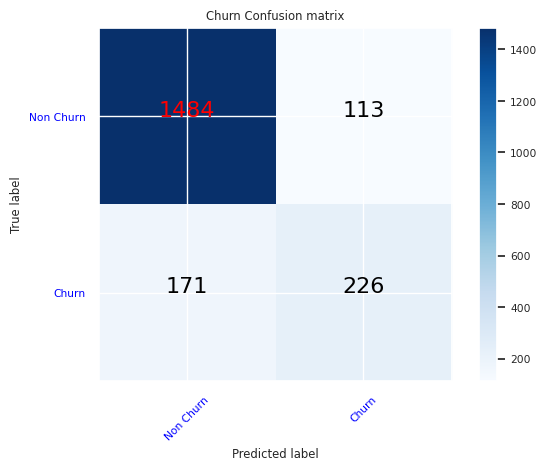

# 10.&nbsp;Confusion Matrix

Confusion matrix, without normalization


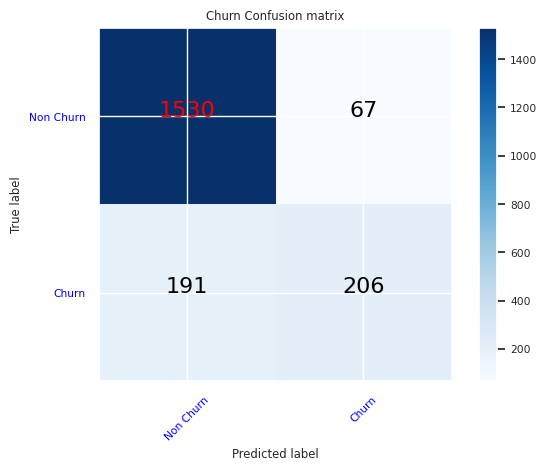

In [395]:
cfm = confusion_matrix(y_test, y_pred=y_pred)
plot_confusion_matrix(
    cfm,
    normalize=False,
    classes=['Non Churn','Churn'],
    title='Churn Confusion matrix'
)

tn, fp, fn, tp = cfm.ravel()

#print("True Negatives: ",tn)
#print("False Positives: ",fp)
#print("False Negatives: ",fn)
#print("True Positives: ",tp)

# 11.&nbsp;ROC Curve

In [396]:
# !pip install --upgrade scipy
# !pip install scikit-plot

In [397]:
# from scipy.interpolate import interp1d
# import matplotlib.pyplot as plt

# y_pred_proba = lgbm_model.predict_proba(X_test)
# skplt.metrics.plot_roc_curve(y_test, y_pred_proba, figsize=(8,8))

# plt.show()


# 12.&nbsp;Feature Importance

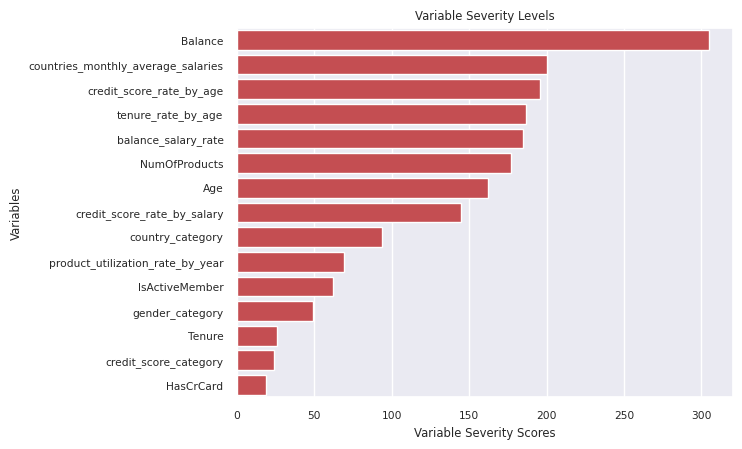

In [398]:
feature_index = df_encoded.loc[:, df_encoded.columns != dependent_variable_name]

feature_importance = pd.Series(
    lgbm_model.feature_importances_,
    index=feature_index.columns
)
feature_importance = feature_importance.sort_values(ascending=False)

sns.barplot(
    x=feature_importance,
    y=feature_importance.index,
    color='r',
    saturation=1
)

plt.xlabel('Variable Severity Scores')
plt.ylabel('Variables')
plt.title('Variable Severity Levels')
plt.show()

# 13.&nbsp;Conclusion



In [399]:
# 1. Storytell setiap bagian 1 - 7
# 2. Model Hyperparameter Tuning, untuk mencari model terbaik (Sesuai diskusi: Recall Tinggi,
# FN yang kecil)

# JAWABAN NO 1 Data Analysis Process

# a. Task 1:
Storytellng bagian 1 - 7


1. **Import Libraries dan Load Dataset:**
   Pada tahap awal analisis data, kita mengimpor semua pustaka yang diperlukan dan memuat dataset dari file CSV yang berisi informasi pelanggan terkait churn dan variabel-variabel terkait.

2. **Eksplorasi Data Awal (EDA):**
   Di tahap ini, kita mempersiapkan dataset dengan menangani nilai yang hilang dan meninjau jumlah nilai unik pada setiap kolom. Selain itu, kita mengamati outliers dan menganalisis distribusi variabel.

3. **Feature Engineering (Pengembangan Fitur):**
   Proses ini melibatkan pembuatan fitur baru seperti tabel skor kredit, tingkat pemanfaatan produk per tahun, tingkat pemanfaatan produk per gaji yang diperkirakan, dan rata-rata gaji bulanan menurut negara.

4. **Data Encoding (Pencocokan Data):**
   Tahap ini melibatkan proses encoding data kategorikal menjadi format yang dapat diinterpretasikan oleh model, seperti Label Encoding dan pembuatan kolom tambahan untuk data kategorikal.

5. **Persiapan Model (Model Preparation):**
   Data dibagi menjadi data latih dan data uji, kemudian dilakukan penskalaan data menggunakan Standard Scaler untuk menormalkan fitur-fitur numerik.

6. **Data Cleaning (Pembersihan Data):**
   Tahap ini mencakup proses pembersihan data seperti penanganan outlier dan penghapusan nilai ekstrim dari beberapa kolom, serta pemrosesan data lanjutan untuk analisis lebih lanjut.

7. **Analisis Data (Data Analysis):**
   Pada tahap terakhir, dilakukan analisis data secara mendalam dengan melihat distribusi variabel dependen dan independen, serta observasi hubungan antar variabel untuk memahami karakteristik data secara holistik.


# b. Task 2:
Storytell setiap bagian 1 - 7

## 1. Import Libraries dan Load Dataset
Pada tahap ini, kita memulai dengan mengimpor semua pustaka yang diperlukan untuk analisis data,
seperti numpy, pandas, seaborn, dan matplotlib. Kemudian dilakukan pembacaan dataset dari file CSV yang berisi
informasi pelanggan terkait churn (pemutusan hubungan) dan variabel-variabel terkait.

## 2. Eksplorasi Data Awal (EDA)

### 2.1. Data Preparation (Persiapan Data)
Langkah pertama dalam eksplorasi data adalah mempersiapkan dataset. Pada tahap ini, dilakukan penanganan terhadap
nilai yang hilang (missing value) jika ada, dan peninjauan terhadap jumlah nilai unik pada setiap kolom.

### 2.2. Observasi Outliers (Pengamatan Outliers)
Pada tahap ini, dilakukan observasi terhadap outliers menggunakan metode Local Outlier Factor (LOF) dan teknik untuk mengatasi outliers dengan membatasi nilai-nilai ekstrim pada beberapa kolom tertentu.

### 2.3. Analisis Data (Data Analysis)
Dilakukan analisis terhadap distribusi variabel dependen (Exited) dan distribusi variabel numerik lainnya. Dilakukan pula visualisasi status variabel lainnya berdasarkan variabel dependen, seperti geografi, jenis kelamin, dan aktivitas anggota.

## 3. Feature Engineering (Pengembangan Fitur)

### 3.1. Pembuatan Tabel Skor Kredit (Credit Score Table)
Tahap ini adalah pengembangan fitur yang melibatkan pembuatan kategori skor kredit berdasarkan rentang nilai skor kredit.

### 3.2. Tingkat Pemanfaatan Produk per Tahun (Product Utilization Rate by Year)
Pengembangan fitur ini menghitung rasio tingkat pemanfaatan produk per tahun berdasarkan jumlah produk yang digunakan dan masa keanggotaan pelanggan.

### 3.3. Tingkat Pemanfaatan Produk per Gaji yang Diperkirakan (Product Utilization Rate by Estimated Salary)
Fitur ini menghitung rasio tingkat pemanfaatan produk berdasarkan jumlah produk yang digunakan dan estimasi gaji pelanggan.

### 3.4. Rata-rata Gaji Bulanan Menurut Negara (Countries Monthly Average Salaries)
Fitur ini menghitung rata-rata gaji bulanan berdasarkan negara (Jerman, Prancis, Spanyol) yang diambil dari estimasi gaji pelanggan.

### 3.5. Metode Utama yang Memulai Semua Pengembangan Fitur
Proses pengembangan fitur diakhiri dengan pemanggilan fungsi ini yang mengaplikasikan semua fitur yang telah dikembangkan ke dalam dataset.

## 4. Data Encoding (Pencocokan Data)
Tahap ini melibatkan proses encoding atau pencocokan data untuk mengubah data kategorikal menjadi format yang dapat diinterpretasikan oleh model, seperti Label Encoding dan pembuatan kolom tambahan untuk data kategorikal.

## 5. Persiapan Model (Model Preparation)
Pada tahap ini, dilakukan persiapan data untuk digunakan dalam model pembelajaran mesin. Data dibagi menjadi data latih (training) dan data uji (testing), kemudian dilakukan penskalaan data menggunakan Standard Scaler untuk menormalkan fitur-fitur numerik.

## 6. Data Cleaning (Pembersihan Data)
Tahap ini mencakup proses pembersihan data yang meliputi penanganan outlier dan penghapusan nilai ekstrim dari beberapa kolom, serta pemrosesan data lanjutan untuk analisis lebih lanjut.

## 7. Analisis Data (Data Analysis)
Pada tahap terakhir, dilakukan analisis data secara mendalam dengan melihat distribusi variabel dependen dan independen, serta observasi hubungan antar variabel dengan tujuan memahami karakteristik data secara holistik sebelum melangkah ke tahap pemodelan.


# [Misc.] LOF Visually Explained

In [400]:
import numpy as np

# Create synthetic dataset
np.random.seed(42)
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]
n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

In [401]:
dataset = pd.DataFrame(
    data={
        'X1': X[:, 0],
        'X2': X[:, 1],
        'ground_truth': ground_truth
    }
)
dataset

,X1,X2,ground_truth
0,2.15,1.96,1
1,2.19,2.46,1
2,1.93,1.93,1
3,2.47,2.23,1
4,1.86,2.16,1
5,1.86,1.86,1
6,2.07,1.43,1
7,1.48,1.83,1
8,1.70,2.09,1
9,1.73,1.58,1


In [402]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

In [403]:
dataset['negative_outlier_factor_'] = X_scores
dataset['prediction'] = y_pred
dataset

,X1,X2,ground_truth,negative_outlier_factor_,prediction
0,2.15,1.96,1,-1.00,1
1,2.19,2.46,1,-1.14,1
2,1.93,1.93,1,-0.97,1
3,2.47,2.23,1,-1.29,1
4,1.86,2.16,1,-0.96,1
5,1.86,1.86,1,-0.97,1
6,2.07,1.43,1,-1.17,1
7,1.48,1.83,1,-1.18,1
8,1.70,2.09,1,-1.01,1
9,1.73,1.58,1,-1.15,1


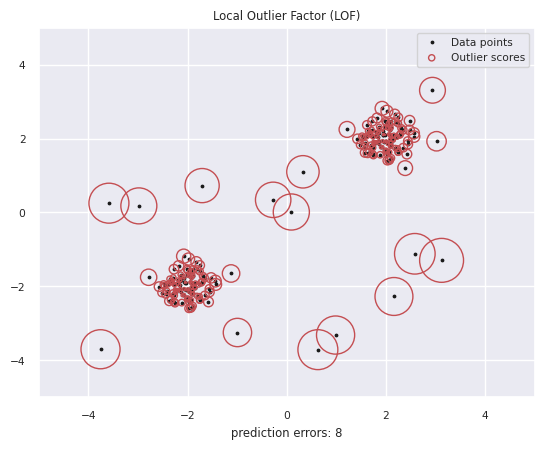

In [404]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection

def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])

plt.scatter(
    X[:, 0], X[:, 1],
    color="k", s=3.0,
    label="Data points"
)

# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

scatter = plt.scatter(
    X[:, 0], X[:, 1],
    s=1000 * radius, edgecolors="r",
    facecolors="none", label="Outlier scores",
)

plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
plt.legend(
    handler_map={
        scatter: HandlerPathCollection(update_func=update_legend_marker_size)
    }
)
plt.title("Local Outlier Factor (LOF)")
plt.show()

In [405]:
dataset['radius'] = radius
dataset

,X1,X2,ground_truth,negative_outlier_factor_,prediction,radius
0,2.15,1.96,1,-1.00,1,0.01
1,2.19,2.46,1,-1.14,1,0.03
2,1.93,1.93,1,-0.97,1,0.00
3,2.47,2.23,1,-1.29,1,0.05
4,1.86,2.16,1,-0.96,1,0.00
5,1.86,1.86,1,-0.97,1,0.00
6,2.07,1.43,1,-1.17,1,0.03
7,1.48,1.83,1,-1.18,1,0.03
8,1.70,2.09,1,-1.01,1,0.01
9,1.73,1.58,1,-1.15,1,0.03


$$ reach-dist(p, o) = \max(\text{dist}(p, o), \text{k-distance}(o)) $$

$$ lrd(p) = \frac{1}{\frac{\sum_{o \in N_k(p)}{\text{reach-dist}(p, o)}}{|N_k(p)|}} $$

$$
\text{LOF}(p) = \frac{\sum_{o \in N_k(p)}{\frac{\text{lrd}(o)}{\text{lrd}(p)}}}{|N_k(p)|}
$$


\